# StackOverflow Query Workshop
<br/>

---

# Counts and basic time series analysis of tags

We'll begin the workshop by looking at the tags provided by the data.  Users, both the question-asker as well as the community at large via the editorial process, consciously label a question with tags.  This is a fantastic data source for thinking about labeled textual data.  But it's also interesting in its own right:  what trends can we see about questions in programming languages?  How do these manifest over time and comparatively?

Let's get started by asking about how R stands relative to other statistical languages as measured by frequency of tags on stackoverflow.


### Tags for other languages

Compare counts of tags over time of R versus other statistical languages.

- R
- pandas
- julia

Using this query:

```SQL 
select *, count(*) from
(
  select CAST(
      cast(DATEPART(YYYY, CreationDate) as varchar) + '-' + 
      cast(DATEPART(MM, CreationDate) as varchar) + '-01'
    as date) Month, 
    t.TagName
  from Posts p 
  join PostTags pt on pt.PostId = p.Id
  join Tags t on t.Id = pt.TagId
  where t.TagName in ('r', 'pandas', 'julia')
) as tmptable
where month between cast('2010-01-01' as date) and cast('2019-08-01' as date)
group by TagName, Month
order by Month desc, count(*) desc
```

From:
https://data.stackexchange.com/stackoverflow/query/1092906/r-v-pandas-v-julia

In [60]:
url <- "https://data.stackexchange.com/stackoverflow/csv/1349395"
fname <- "data/counts/StackOverFlowStatsTagstop3.csv"
download.file(url, fname)

In [61]:
df <- read.csv(fname, stringsAsFactors=F)
colnames(df) <- c("month", "tag", "count")
df$month <- as.Date(df$month)
df_wide <- reshape(df, idvar="month", timevar="tag", direction="wide")
df_wide <- df_wide[-1,] # get complete months only, omit this month
df_wide <- df_wide[df_wide$month >= as.Date("2013-01-1"),]
colnames(df_wide) <- c("month", "r", "pandas", "julia")
head(df_wide)

,month,r,pandas,julia
,<date>,<int>,<int>,<int>
4,2019-07-01,5088,3908,114
7,2019-06-01,4619,3247,117
10,2019-05-01,5038,3445,144
13,2019-04-01,5358,3470,106
16,2019-03-01,5166,3530,124
19,2019-02-01,4919,3205,100


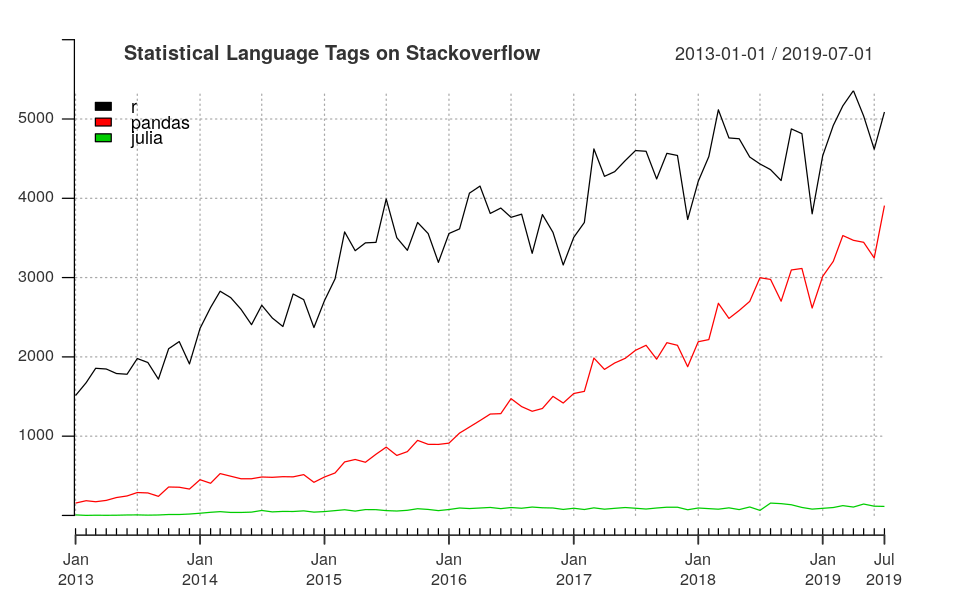

In [62]:
require(xts)
options(repr.plot.width=8, repr.plot.height=5)
ts <- xts(df_wide[,-1], order.by=as.Date(df_wide$month))
plot(ts, 
     main="\tStatistical Language Tags on Stackoverflow",
     legend.loc='topleft', 
     yaxis.right=FALSE,
     lwd=1,
     major.ticks="years",
     grid2=NULL, 
     grid.ticks.lty=3)

axis(side=2,labels=F,lty=1,lwd=1, col="black", line=1) # Darker left axis

I'm surprised Julia isn't higher

## Let's broaden that

This time, let's include:

- r 
- pandas
- julia 
- excel 
- spss
- sas

Using this query:

```SQL
select *, count(*) from
(
  select CAST(
      cast(DATEPART(YYYY, CreationDate) as varchar) + '-' + 
      cast(DATEPART(MM, CreationDate) as varchar) + '-01'
    as date) Month, 
    t.TagName
  from Posts p 
  join PostTags pt on pt.PostId = p.Id
  join Tags t on t.Id = pt.TagId
  where t.TagName in ('r', 'pandas', 'julia', 'excel', 'spss', 'sas')
) as tmptable
where month between cast('2010-01-01' as date) and cast('2019-08-01' as date)
group by TagName, Month
order by Month desc, count(*) desc
```

from: https://data.stackexchange.com/stackoverflow/query/1092908/r-v-pandas-v-julia-vs-excel-vs-spss-vs-sas

In [63]:
url <- "https://data.stackexchange.com/stackoverflow/csv/1349397"
fname <- "data/counts/StackOverFlowStatsTagstop6.csv"
download.file(url, fname)

In [64]:
df <- read.csv(fname, stringsAsFactors=F)
colnames(df) <- c("month", "tag", "count")
df$month <- as.Date(df$month)
df_wide <- reshape(df, idvar="month", timevar="tag", direction="wide")
df_wide <- df_wide[-1,] # get complete months only, omit this month
df_wide <- df_wide[df_wide$month >= as.Date("2013-01-1"),]
colnames(df_wide) <- c("month", "r", "pandas", "excel", "julia", "sas", "spss")
head(df_wide)

,month,r,pandas,excel,julia,sas,spss
,<date>,<int>,<int>,<int>,<int>,<int>,<int>
7,2019-07-01,5088,3908,3063,114,129,24
13,2019-06-01,4619,3247,2649,117,106,19
19,2019-05-01,5038,3445,2828,144,128,15
25,2019-04-01,5358,3470,2491,106,142,25
31,2019-03-01,5166,3530,2892,124,127,14
37,2019-02-01,4919,3205,2573,100,110,19


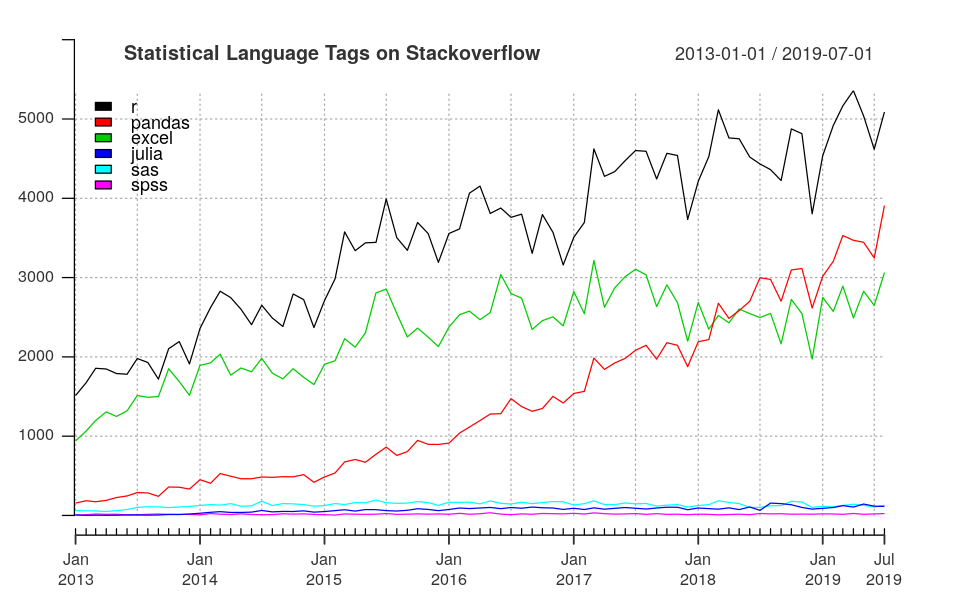

In [65]:
ts <- xts(df_wide[,-1], order.by=as.Date(df_wide$month))
plot(ts, 
     main="\tStatistical Language Tags on Stackoverflow",
     legend.loc='topleft', 
     yaxis.right=FALSE,
     lwd=1,
     major.ticks="years",
     grid2=NULL, 
     grid.ticks.lty=3)

axis(side=2,labels=F,lty=1,lwd=1, col="black", line=1) # Darker left axis

## Other queries that might interest you


### Topics

- R and tidy
https://api.stackexchange.com/docs/questions#fromdate=2011-01-01&todate=2019-06-01&order=desc&sort=creation&tagged=R;tidy&filter=default&site=stackoverflow

- R and machine-learning
https://api.stackexchange.com/docs/questions#fromdate=2011-01-01&todate=2019-06-01&order=desc&sort=creation&tagged=R;machine-learning&filter=default&site=stackoverflow

- R and optimization
https://api.stackexchange.com/docs/questions#fromdate=2011-01-01&todate=2019-06-01&order=desc&sort=creation&tagged=R;optimization&filter=default&site=stackoverflow

- R and GIS
https://api.stackexchange.com/docs/questions#fromdate=2011-01-01&todate=2019-06-01&order=desc&sort=creation&tagged=R;GIS&filter=default&site=stackoverflow


## Another handy function in xts

Before the workshop, let's introduce the lag operator.  Commonly, you will subtract a series from a previous observation to first-difference it.  This often makes a series statistically stationary and more amenable to analysis.

In our case...

In [49]:
tsdiff <- ts - lag(ts)
tail(tsdiff)

              r pandas excel julia sas spss
2019-02-01  382    189  -177    10  -5   -1
2019-03-01  247    325   319    24  17   -5
2019-04-01  192    -60  -401   -18  15   11
2019-05-01 -320    -25   337    38 -14  -10
2019-06-01 -419   -198  -179   -27 -22    4
2019-07-01  469    661   414    -3  23    5

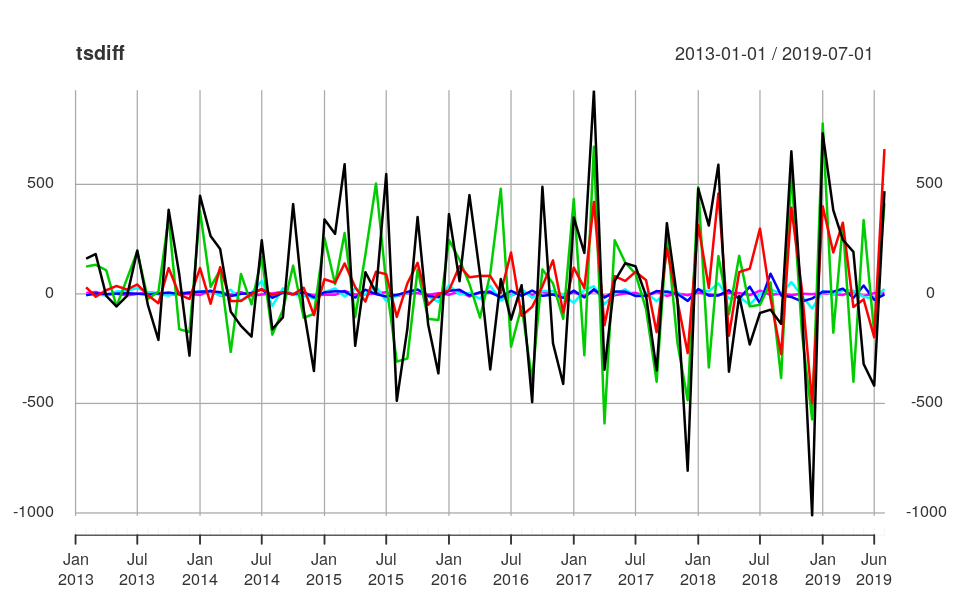

In [52]:
plot(tsdiff)

### Stationarity

You can see this actually still is not stationary in that the variance is visibly increasing over time.  Let's consider how to quantify this as one workshop topic.  Hint: look up ACF and PACF.

# WORKSHOP


- How would you change the queries we introduced to study what share of R questions are about ggplot? xts? data.table? Tidyverse? Are these changing over time or stable? 
- Modeling question: is more questions actually a good proxy for popularity?  A sign of more beginners? What is valuable to model?
- How would you forecast the future of R?
- On what date will pandas overtake R with 95% confidence?  Julia?